### Watershed Implementation using CV2

---

In this notebook, I will be exploring the watershed transform. I will also be explaining all the cv2 functions used.

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

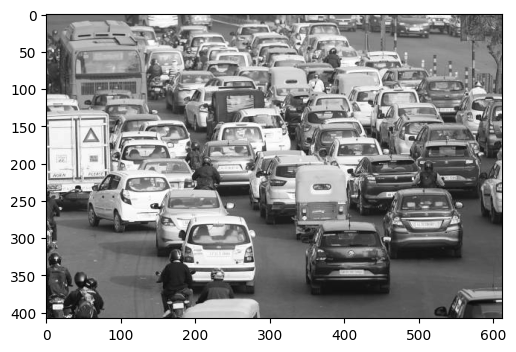

In [14]:
img = cv.imread('/content/demo1.jpg') # read image
img_RGB = cv.cvtColor(img,cv.COLOR_BGR2RGB) # we can convert the colorspace of the image using cvtColor(). For example converting to HSV we can use in Object Tracking, converting to Gray we can use in image processing where color is not required.
img = cv.cvtColor(img,cv.COLOR_BGR2GRAY) # above we extracted the RGB components if we ever need them before converting the colorspace to gray

plt.figure(figsize = (20, 20)) # we use matplotlib to see the output images
plt.subplot(231)
plt.imshow(img,cmap='gray')

We will work with this image of traffic. Image credits to the respective photographer.

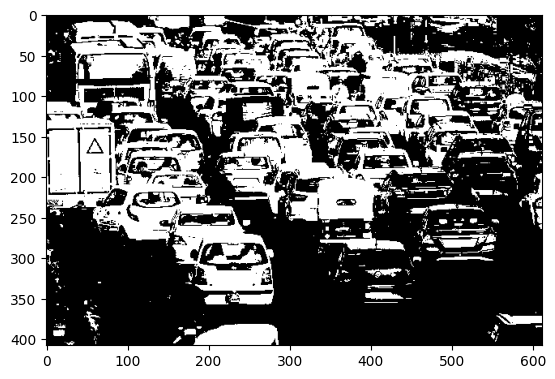

In [32]:
## img_double = img.astype(np.float64)

# Display the image
#plt.imshow(img_double, cmap='gray')
##plt.colorbar()  # Show color scale for reference
#plt.show()

# Print the converted matrix for inspection
#print("Converted Image Matrix (Double Precision):")
#print(img_double)

# Above we visualized the image as a colorbar to see what our threshold value should be for the best segmentation.

_, img_thresh = cv.threshold(img,145,255,cv.THRESH_BINARY) # cv.threshold() performs thresholding
plt.subplot(111)
plt.imshow(img_thresh,cmap='gray')

### THRESH_BINARY

Python: `cv.THRESH_BINARY`

---

$$
\text{dst}(x, y) =
\begin{cases}
\text{max_value} & \text{if } \text{src}(x, y) > \text{threshold_value} \\
0 & \text{otherwise}
\end{cases}
$$

We have chosen a threshold value of 145 after analysing the colorbar. If our background was lighter than the foreground we would have used `cv.THRESH_BINARY_INV` which does the exact opposite. The resultant image has the cars slightly segmented but this is not usable.

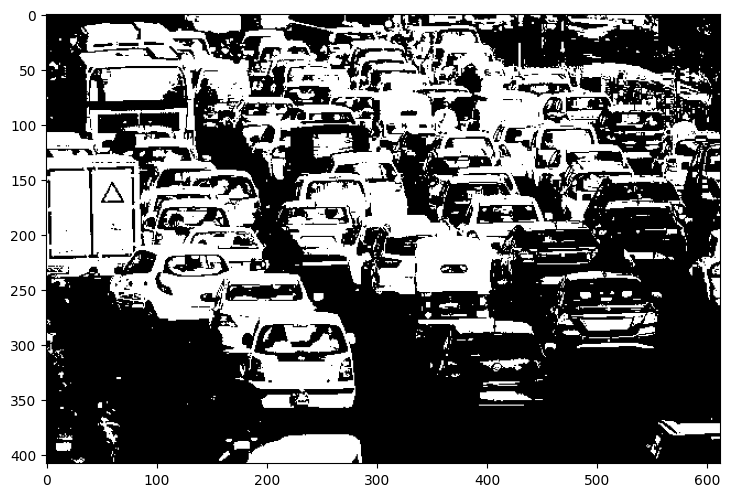

In [72]:
kernel = np.ones((1,1), np.uint8)
img_dilate = cv.morphologyEx(img_thresh, cv.MORPH_DILATE, kernel)

plt.figure(figsize = (40, 40))
plt.subplot(141)
plt.imshow(img_dilate, cmap='gray')

### What is the idea here?
---
`cv.morphologyEx()` performs morphological transformations using the input kernel. Two of the most important ones are erosion and dilation. They do exactly what they say, `cv.MORPH_EROSION` erodes away the boundaries of the object and shrinks it. If all the numbers under the kernel are '1', then it puts a 1 otherwise 0. `cv.MORPH_DILATE` dilates the image by putting a 1 if at least one element under the kernel is 1.

### Why do we do this?
---
During thresholding, some boundaries could have been broken and the object might be unconnected. We perform dilation to rejoin those boundaries.

### Kernel Size
---
I will try various kernel sizes to see what fits best. The idea is that a larger kernel leads to greater dilation, which doesn't work in out case. I start with a 2 $\times$ 2 kernel. If the segmentation doesn't work, I will remove the kernel all together.

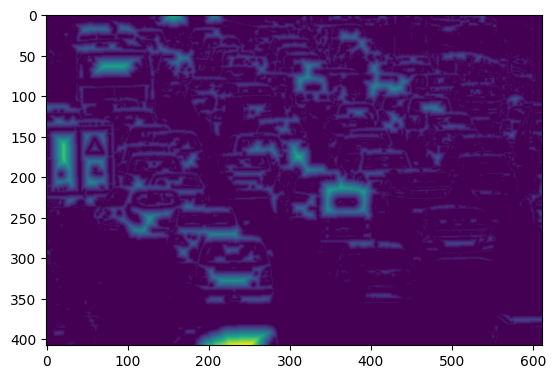

In [73]:
dist_trans = cv.distanceTransform(img_dilate, cv.DIST_L2, 5)
plt.imshow(dist_trans)

### Distance Transform
---
This function finds the distance to the closest '0' valued pixel and returns the distance map. We use this to find the centres of the regions we will later segment. In our case we use the L2 norm to find the distance.

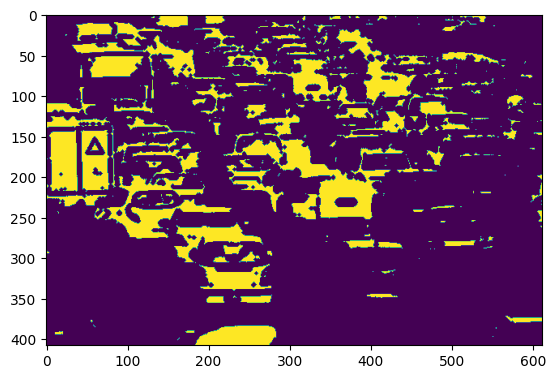

In [87]:
_, dist_thresh = cv.threshold(dist_trans, 2, 255, cv.THRESH_BINARY)
plt.imshow(dist_thresh)

### Thresholding again?
---
We want to separate out the regions that we formed using the distance transform, so after checking the colorbar for this image we decide on a threshold and what we get as the output is an image where we have clear, distinct regions. Next we will label each region differently using `cv.connectedComponents()`.


---


The output image may look completely non-intuitive as to how it will segment correctly when the regions look so random. But we need to understand that the water sources will be placed in these regions, the watershed will reform the correct boundaries as you will see later.

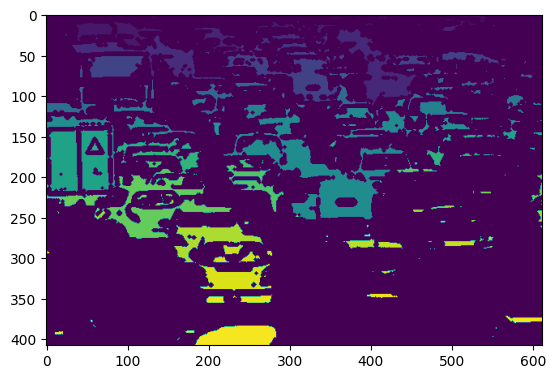

In [88]:
dist_thresh = np.uint8(dist_thresh)
_, labels = cv.connectedComponents(dist_thresh)
plt.imshow(labels)

### Why the need to label?
---
We extract labels this way because `cv.watershed()` takes these labels as input. The reason for this has been explained in the previous markdown box.

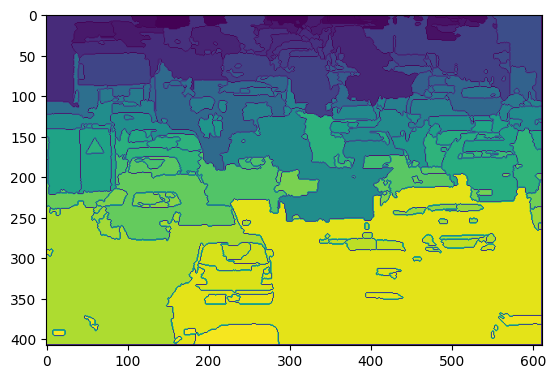

In [89]:
labels = np.int32(labels)
labels = cv.watershed(img_RGB, labels)
plt.imshow(labels)

### Result
---
The result shows some level of segmentation which is indicative of the power of watershed transform. These days most people use AI/ML techniques to perform image segmentation.

For simpler images, watershed does really well. I will create a function for it and perform the transform on various images.

In [160]:
def watershed(img,kernel_size,mask,threshold_1,threshold_2):
  img_RGB = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

  plt.figure(figsize=(25,25))
  plt.subplot(231)
  plt.imshow(img, cmap='gray')
  plt.title('Original Image')

  _, img_thresh = cv.threshold(img,threshold_1,255,cv.THRESH_BINARY_INV)

  plt.subplot(232)
  plt.imshow(img_thresh, cmap='gray')
  plt.title('Thresholded Image')

  kernel = np.ones((kernel_size,kernel_size), np.uint8)
  img_dilate = cv.morphologyEx(img_thresh, cv.MORPH_DILATE, kernel)

  plt.subplot(233)
  plt.imshow(img_dilate, cmap='gray')
  plt.title('Dilated Image')

  dist_trans = cv.distanceTransform(img_dilate, cv.DIST_L2, mask)

  plt.subplot(234)
  plt.imshow(dist_trans)
  plt.title('Distance Transform')

  _, dist_thresh = cv.threshold(dist_trans, threshold_2, 255, cv.THRESH_BINARY)

  plt.subplot(235)
  plt.imshow(dist_thresh)
  plt.title('Thresholded Distance Transform')

  dist_thresh = np.uint8(dist_thresh)
  _, labels = cv.connectedComponents(dist_thresh)

  plt.subplot(236)
  plt.imshow(labels)
  plt.title('Connected Components')

  labels = np.int32(labels)
  labels = cv.watershed(img_RGB, labels)

  plt.figure(figsize=(25,25))
  plt.subplot(181)
  plt.imshow(labels)
  labels = labels.astype(np.uint8)
  return labels

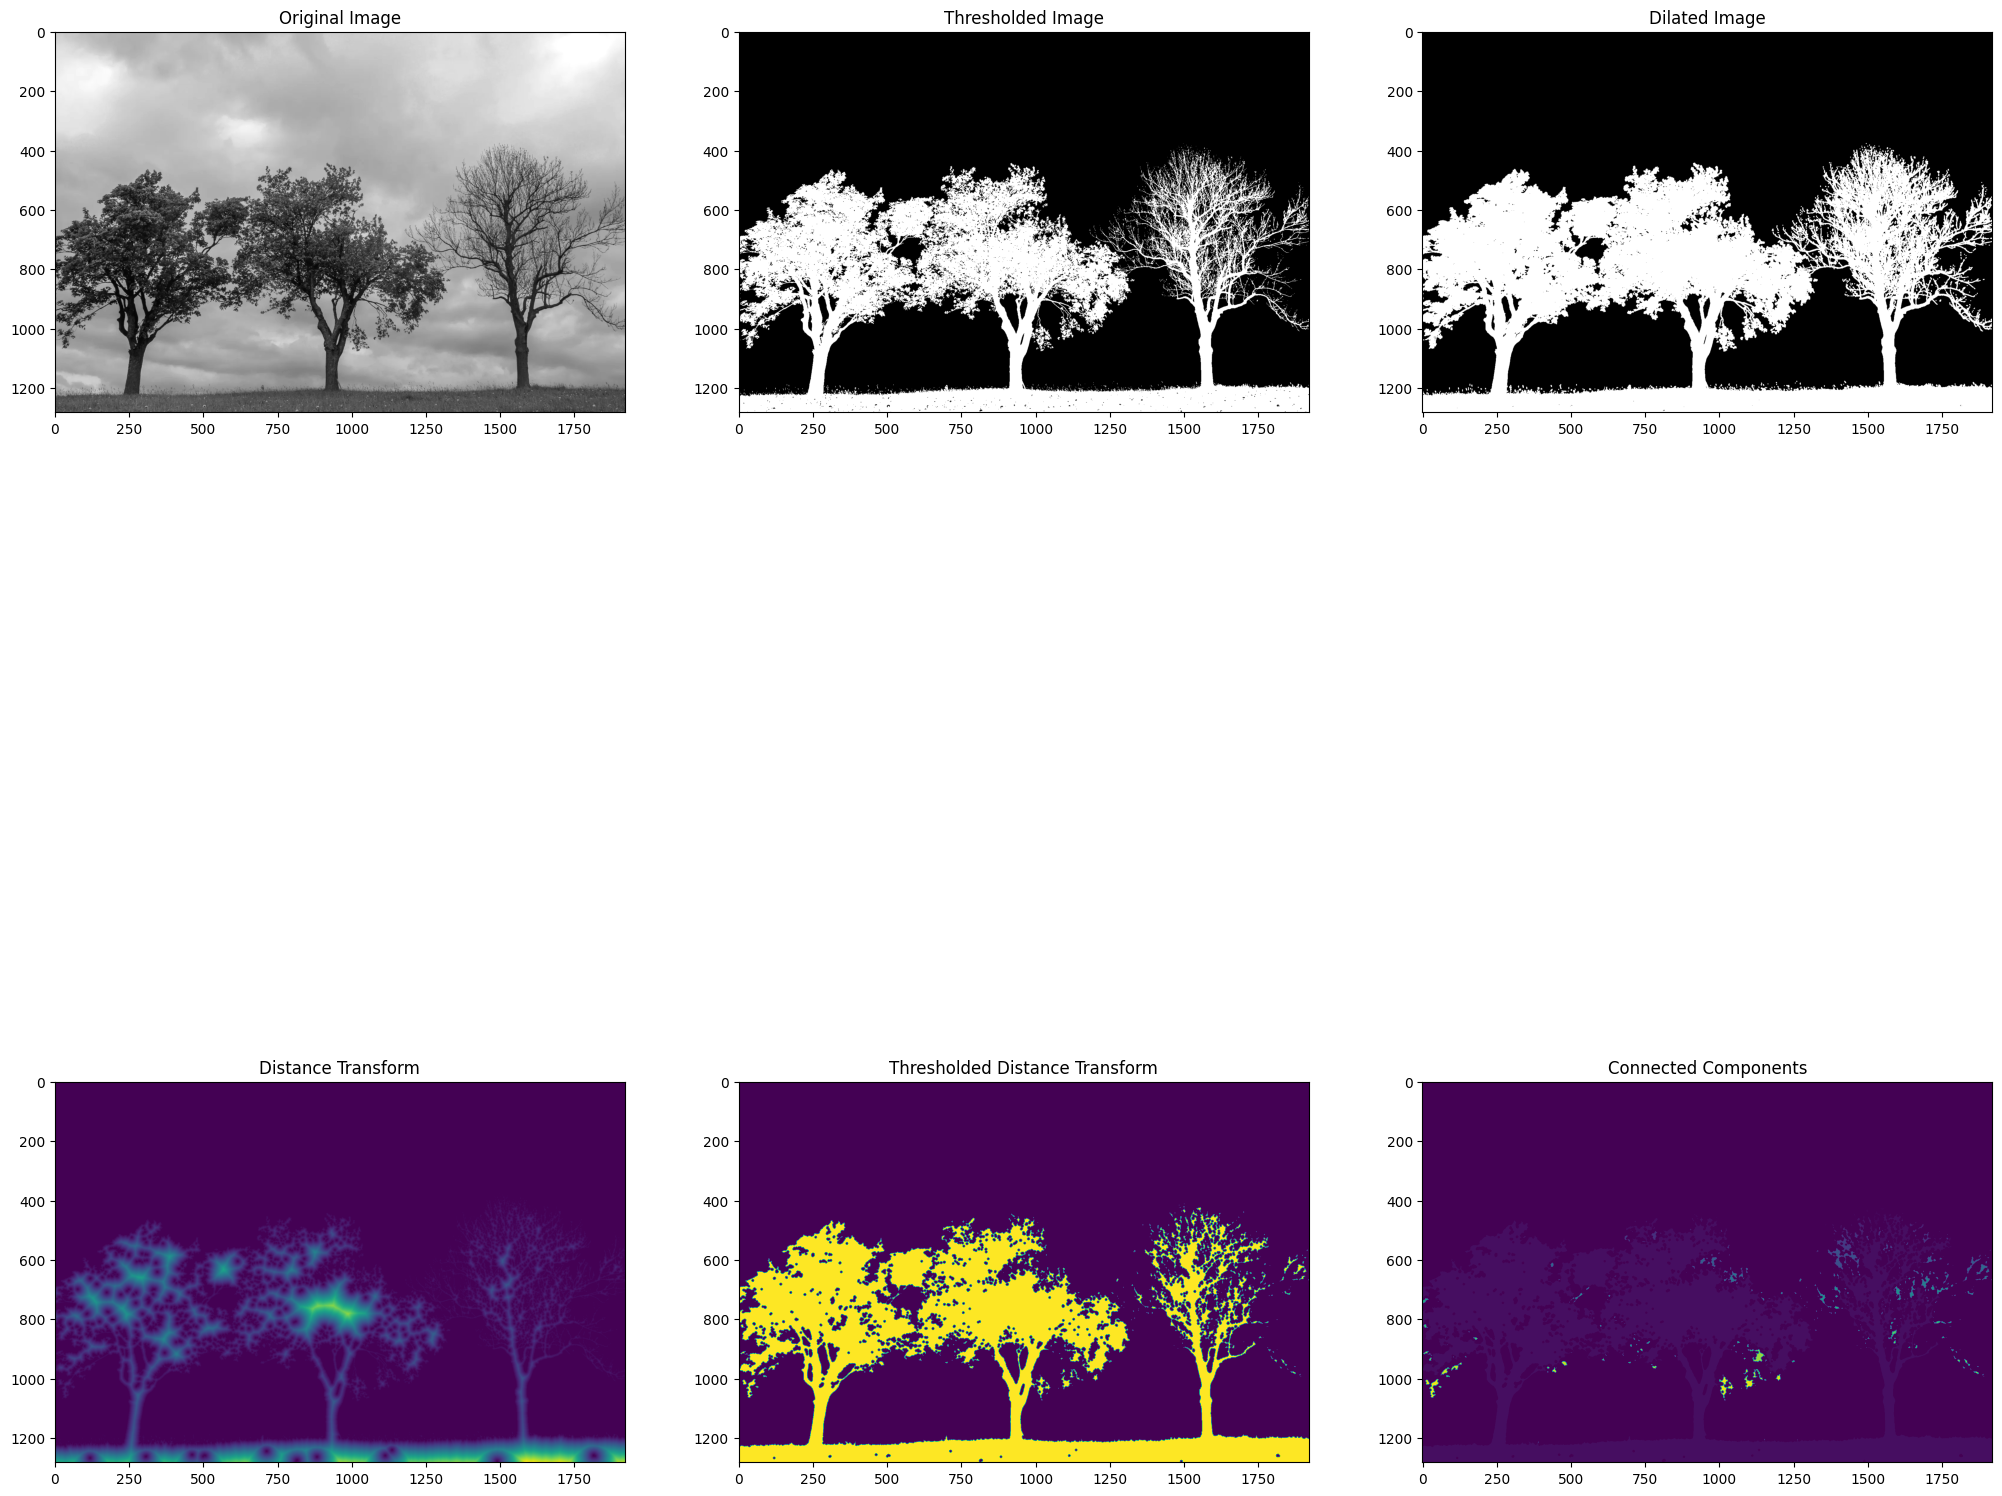

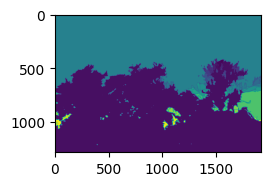

In [149]:
img2 = cv.imread('/content/demo2.png')
watershed(img2,3,5,120,4)

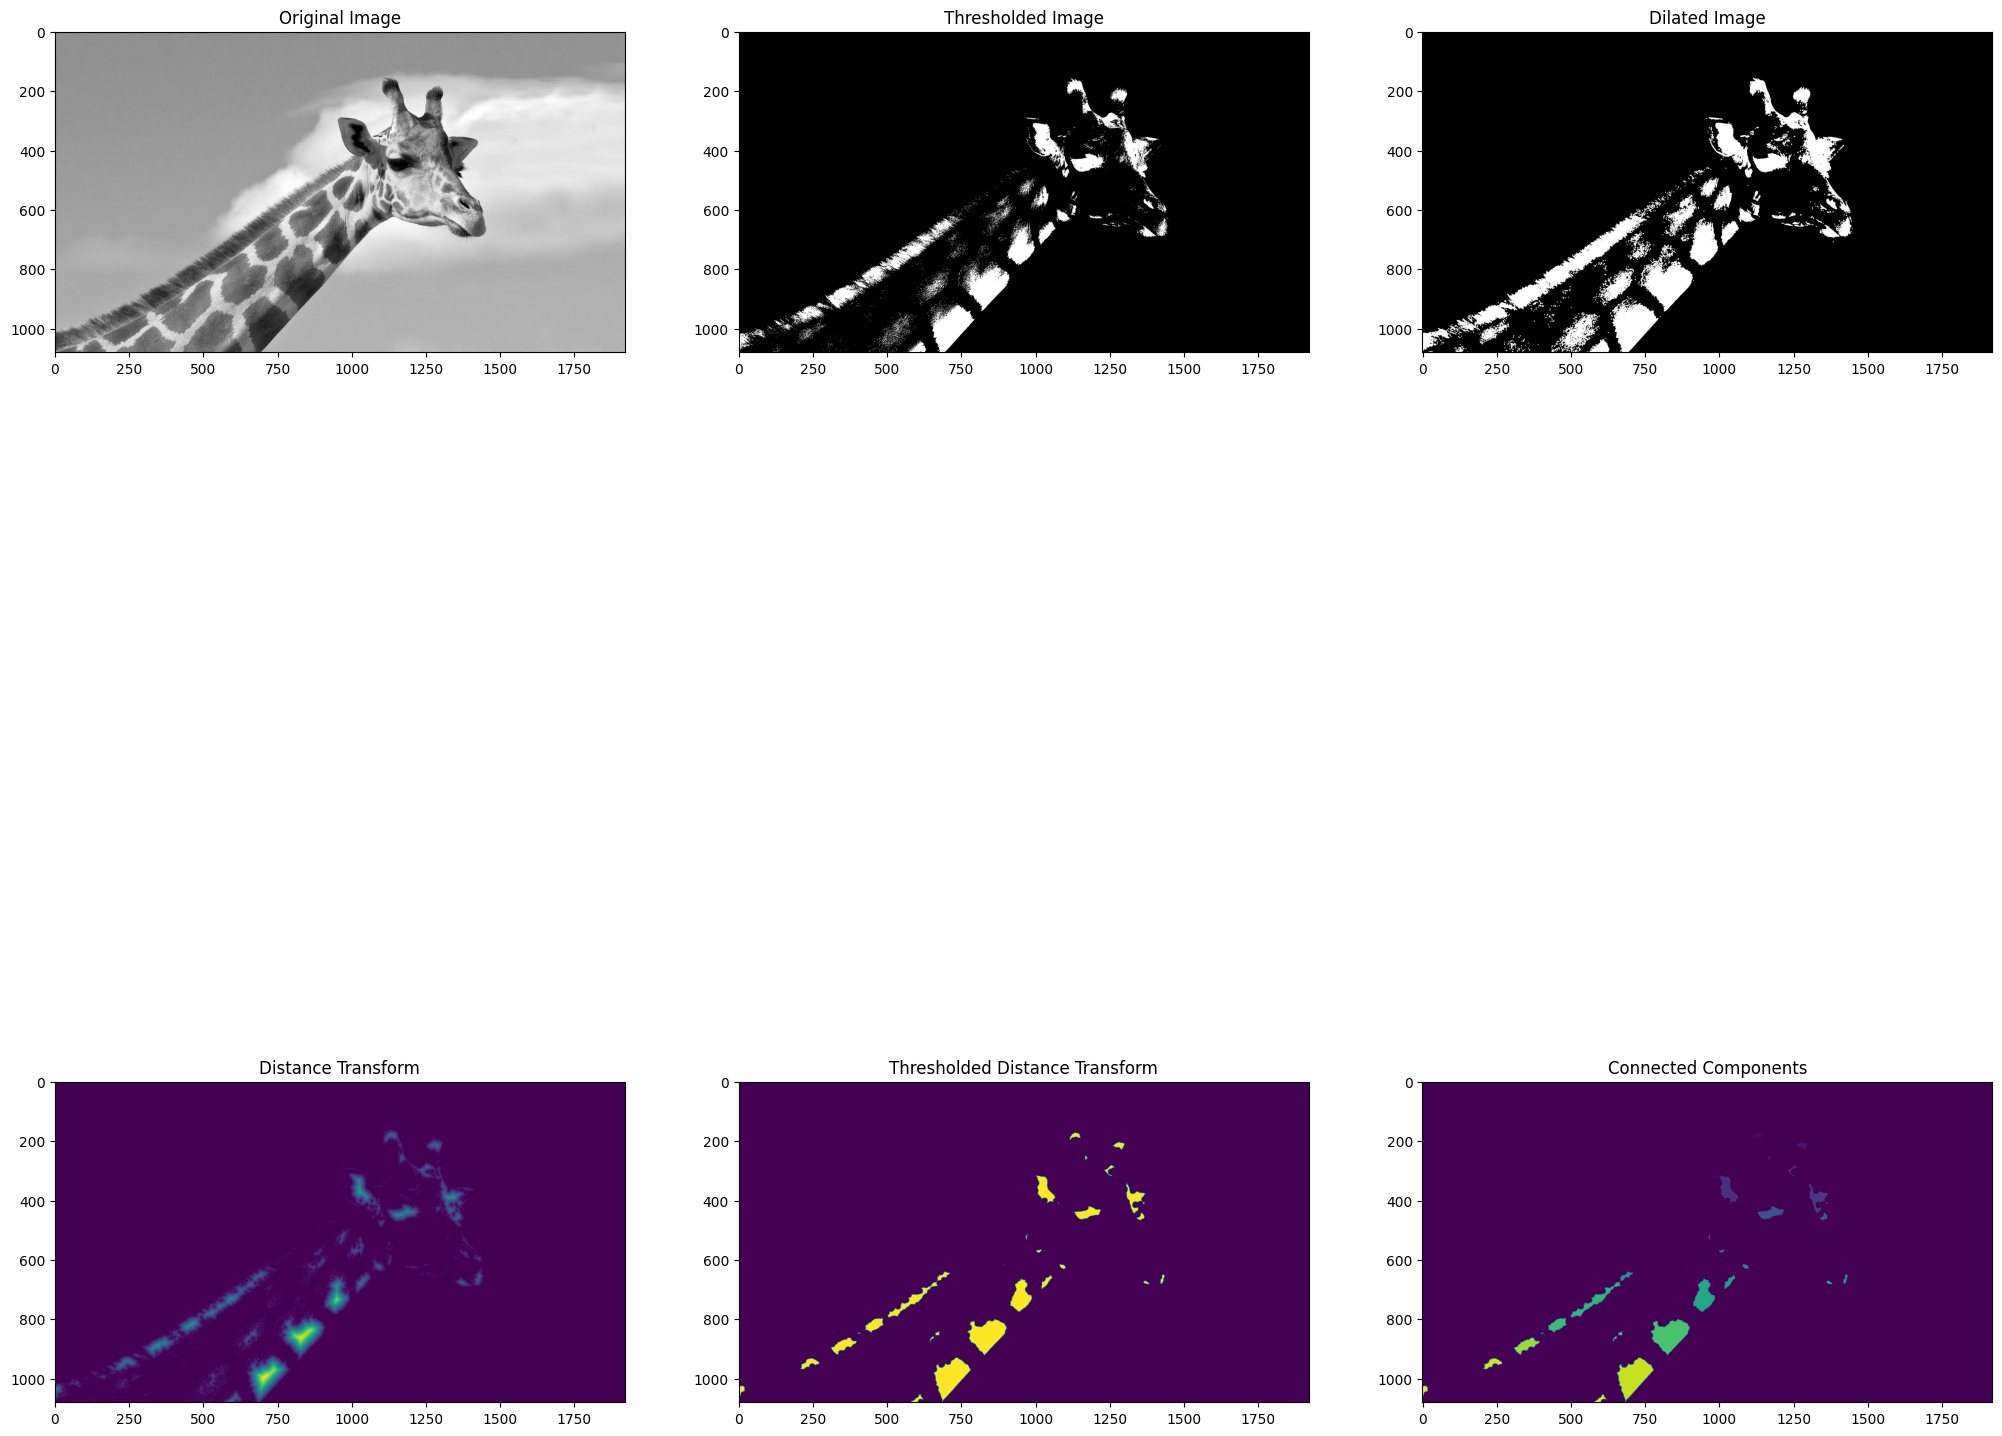

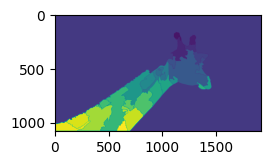

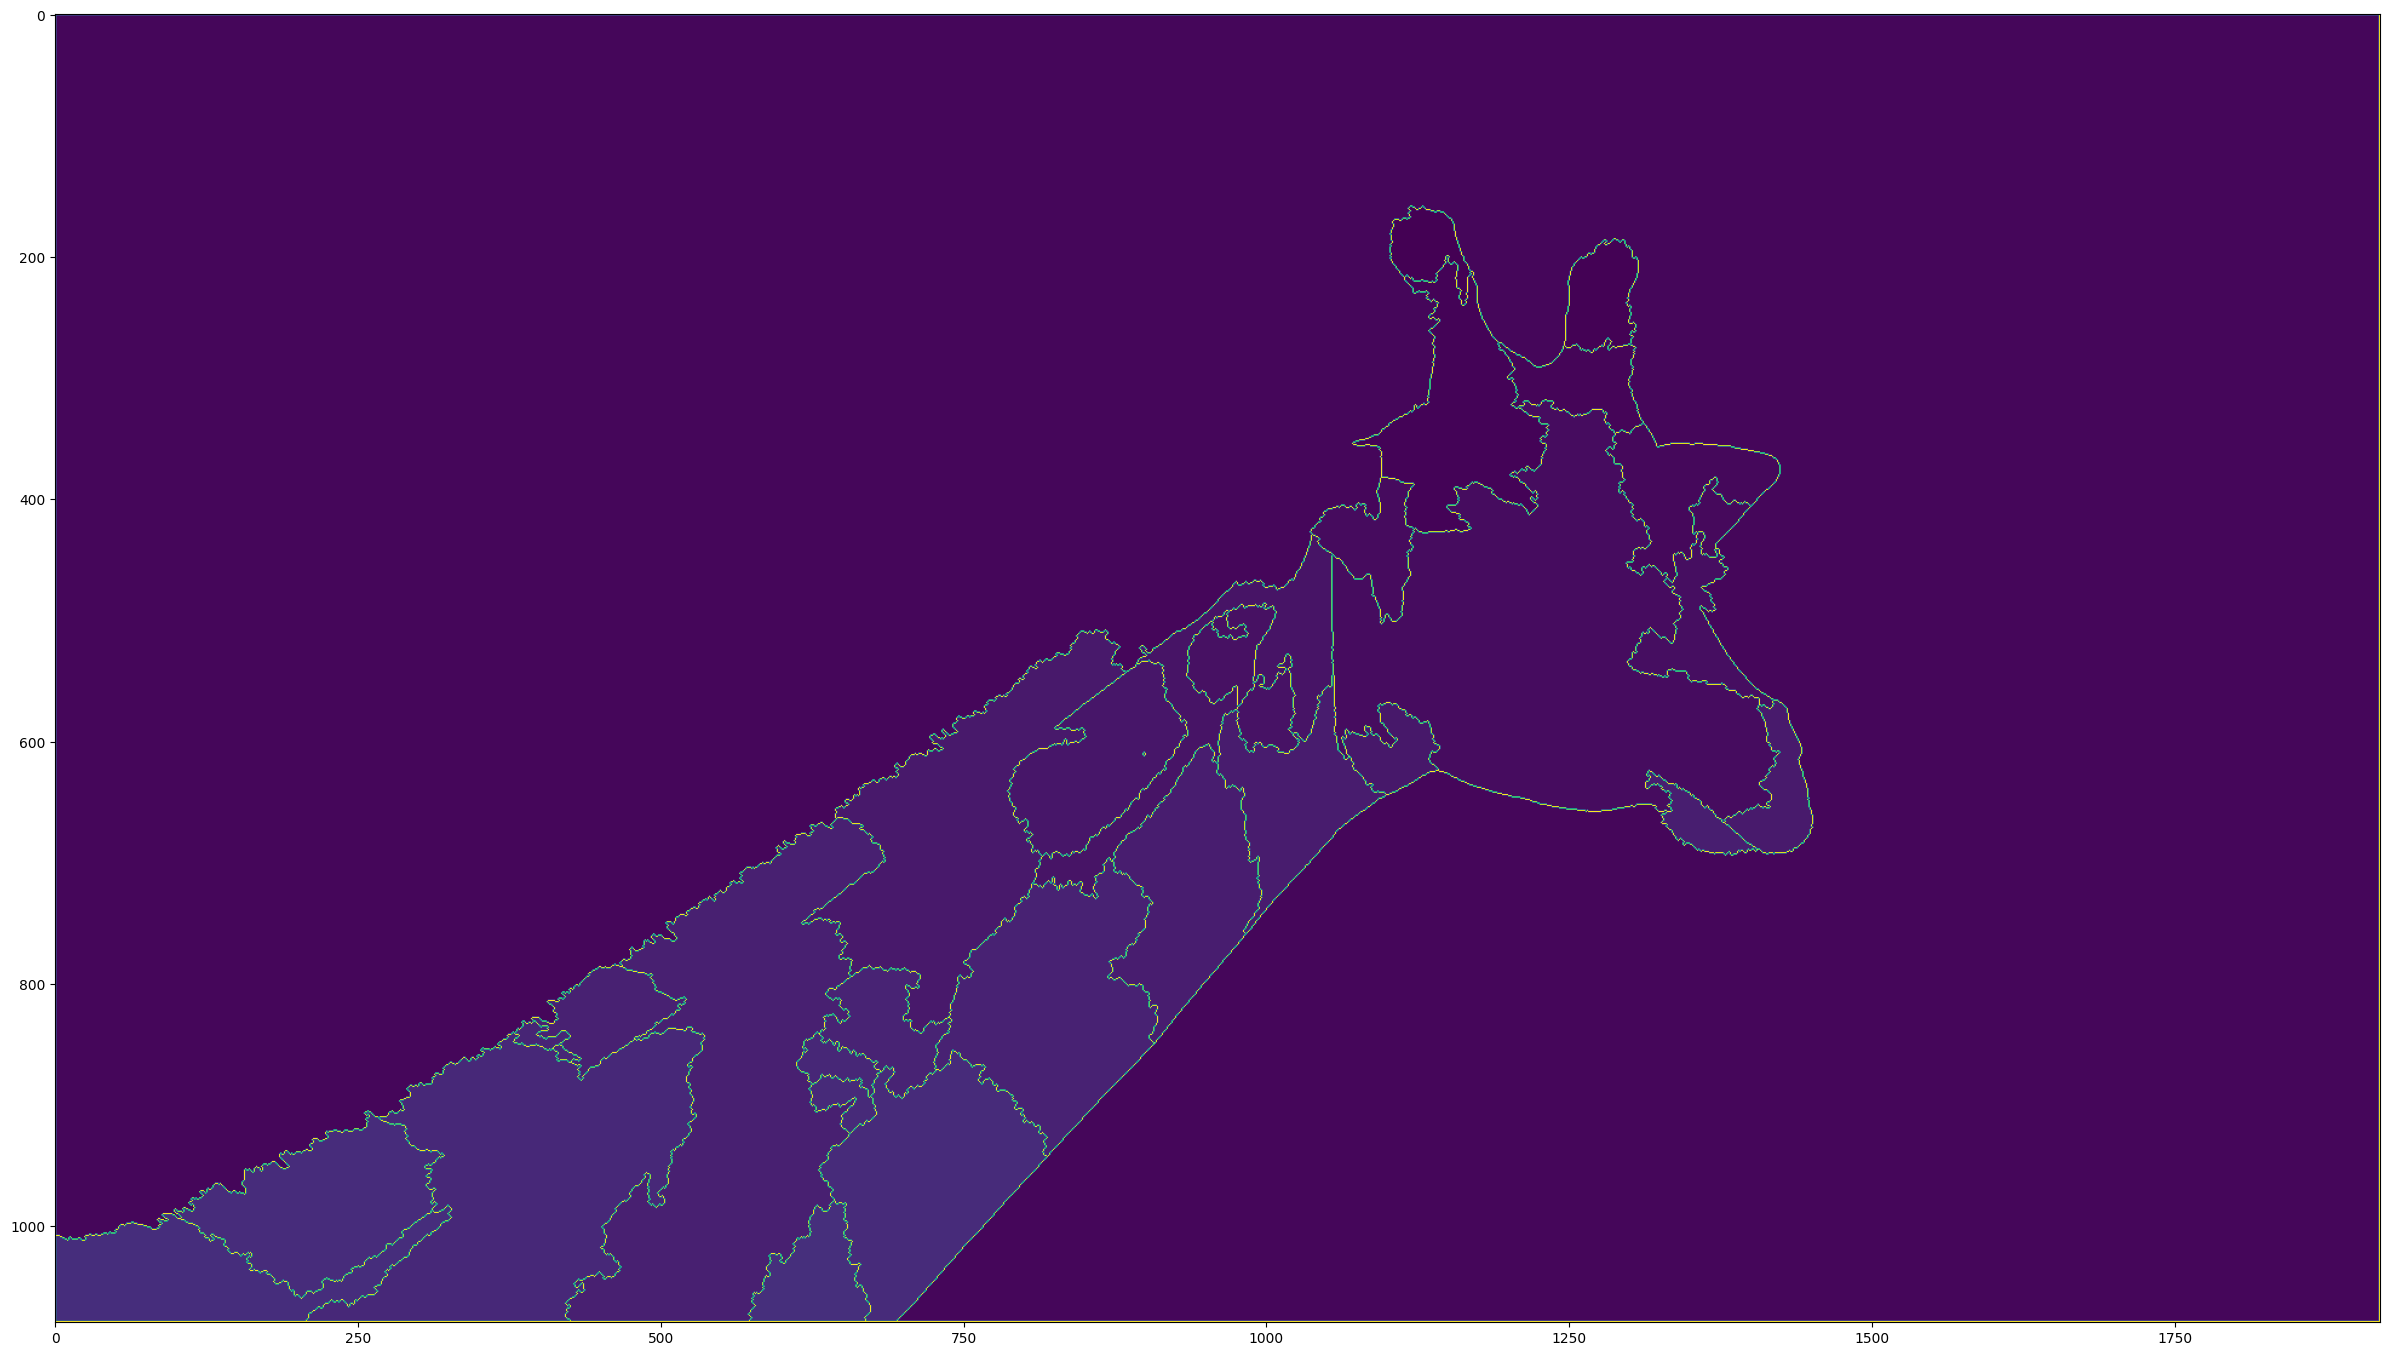

In [161]:
img2 = cv.imread('/content/demo3.jpg')
get = watershed(img2,3,5,85,10)

plt.figure(figsize=(30,30))
plt.imshow(get)

With a simpler image, the segmentation worked pretty well!